In [1]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import optuna
import pickle
from datetime import timedelta
import time
import os 
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-14 13:45:53.759782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 13:45:54.347751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

tf.keras.backend.clear_session()
gc.collect()

0

In [3]:
feat = pd.read_csv('./data/test.csv')
FEATURE_COLS = feat.columns[1:].tolist()

In [4]:
study_name = '513_combined_fold_1_3'

In [5]:


pickle_file_path = f'./data/train_df.pickle'

with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)

In [6]:
pickle_file_path = f'./data/test_df.pickle'

with open(pickle_file_path, 'rb') as f:
    test_df = pickle.load(f)

In [7]:
pd.set_option('display.max_rows', None)

# Aseta näyttämään rajoittamaton määrä sarakkeita
pd.set_option('display.max_columns', None)

In [8]:
train_df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,SOIL_bdod_5.15cm_mean_0.01_deg,SOIL_bdod_60.100cm_mean_0.01_deg,SOIL_cec_0.5cm_mean_0.01_deg,SOIL_cec_100.200cm_mean_0.01_deg,SOIL_cec_15.30cm_mean_0.01_deg,SOIL_cec_30.60cm_mean_0.01_deg,SOIL_cec_5.15cm_mean_0.01_deg,SOIL_cec_60.100cm_mean_0.01_deg,SOIL_cfvo_0.5cm_mean_0.01_deg,SOIL_cfvo_100.200cm_mean_0.01_deg,SOIL_cfvo_15.30cm_mean_0.01_deg,SOIL_cfvo_30.60cm_mean_0.01_deg,SOIL_cfvo_5.15cm_mean_0.01_deg,SOIL_cfvo_60.100cm_mean_0.01_deg,SOIL_clay_0.5cm_mean_0.01_deg,SOIL_clay_100.200cm_mean_0.01_deg,SOIL_clay_15.30cm_mean_0.01_deg,SOIL_clay_30.60cm_mean_0.01_deg,SOIL_clay_5.15cm_mean_0.01_deg,SOIL_clay_60.100cm_mean_0.01_deg,SOIL_nitrogen_0.5cm_mean_0.01_deg,SOIL_nitrogen_100.200cm_mean_0.01_deg,SOIL_nitrogen_15.30cm_mean_0.01_deg,SOIL_nitrogen_30.60cm_mean_0.01_deg,SOIL_nitrogen_5.15cm_mean_0.01_deg,SOIL_nitrogen_60.100cm_mean_0.01_deg,SOIL_ocd_0.5cm_mean_0.01_deg,SOIL_ocd_100.200cm_mean_0.01_deg,SOIL_ocd_15.30cm_mean_0.01_deg,SOIL_ocd_30.60cm_mean_0.01_deg,SOIL_ocd_5.15cm_mean_0.01_deg,SOIL_ocd_60.100cm_mean_0.01_deg,SOIL_ocs_0.30cm_mean_0.01_deg,SOIL_phh2o_0.5cm_mean_0.01_deg,SOIL_phh2o_100.200cm_mean_0.01_deg,SOIL_phh2o_15.30cm_mean_0.01_deg,SOIL_phh2o_30.60cm_mean_0.01_deg,SOIL_phh2o_5.15cm_mean_0.01_deg,SOIL_phh2o_60.100cm_mean_0.01_deg,SOIL_sand_0.5cm_mean_0.01_deg,SOIL_sand_100.200cm_mean_0.01_deg,SOIL_sand_15.30cm_mean_0.01_deg,SOIL_sand_30.60cm_mean_0.01_deg,SOIL_sand_5.15cm_mean_0.01_deg,SOIL_sand_60.100cm_mean_0.01_deg,SOIL_silt_0.5cm_mean_0.01_deg,SOIL_silt_100.200cm_mean_0.01_deg,SOIL_silt_15.30cm_mean_0.01_deg,SOIL_silt_30.60cm_mean_0.01_deg,SOIL_silt_5.15cm_mean_0.01_deg,SOIL_silt_60.100cm_mean_0.01_deg,SOIL_soc_0.5cm_mean_0.01_deg,SOIL_soc_100.200cm_mean_0.01_deg,SOIL_soc_15.30cm_mean_0.01_deg,SOIL_soc_30.60cm_mean_0.01_deg,SOIL_soc_5.15cm_mean_0.01_deg,SOIL_soc_60.100cm_mean_0.01_deg,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_ban

In [9]:
test_df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,SOIL_bdod_5.15cm_mean_0.01_deg,SOIL_bdod_60.100cm_mean_0.01_deg,SOIL_cec_0.5cm_mean_0.01_deg,SOIL_cec_100.200cm_mean_0.01_deg,SOIL_cec_15.30cm_mean_0.01_deg,SOIL_cec_30.60cm_mean_0.01_deg,SOIL_cec_5.15cm_mean_0.01_deg,SOIL_cec_60.100cm_mean_0.01_deg,SOIL_cfvo_0.5cm_mean_0.01_deg,SOIL_cfvo_100.200cm_mean_0.01_deg,SOIL_cfvo_15.30cm_mean_0.01_deg,SOIL_cfvo_30.60cm_mean_0.01_deg,SOIL_cfvo_5.15cm_mean_0.01_deg,SOIL_cfvo_60.100cm_mean_0.01_deg,SOIL_clay_0.5cm_mean_0.01_deg,SOIL_clay_100.200cm_mean_0.01_deg,SOIL_clay_15.30cm_mean_0.01_deg,SOIL_clay_30.60cm_mean_0.01_deg,SOIL_clay_5.15cm_mean_0.01_deg,SOIL_clay_60.100cm_mean_0.01_deg,SOIL_nitrogen_0.5cm_mean_0.01_deg,SOIL_nitrogen_100.200cm_mean_0.01_deg,SOIL_nitrogen_15.30cm_mean_0.01_deg,SOIL_nitrogen_30.60cm_mean_0.01_deg,SOIL_nitrogen_5.15cm_mean_0.01_deg,SOIL_nitrogen_60.100cm_mean_0.01_deg,SOIL_ocd_0.5cm_mean_0.01_deg,SOIL_ocd_100.200cm_mean_0.01_deg,SOIL_ocd_15.30cm_mean_0.01_deg,SOIL_ocd_30.60cm_mean_0.01_deg,SOIL_ocd_5.15cm_mean_0.01_deg,SOIL_ocd_60.100cm_mean_0.01_deg,SOIL_ocs_0.30cm_mean_0.01_deg,SOIL_phh2o_0.5cm_mean_0.01_deg,SOIL_phh2o_100.200cm_mean_0.01_deg,SOIL_phh2o_15.30cm_mean_0.01_deg,SOIL_phh2o_30.60cm_mean_0.01_deg,SOIL_phh2o_5.15cm_mean_0.01_deg,SOIL_phh2o_60.100cm_mean_0.01_deg,SOIL_sand_0.5cm_mean_0.01_deg,SOIL_sand_100.200cm_mean_0.01_deg,SOIL_sand_15.30cm_mean_0.01_deg,SOIL_sand_30.60cm_mean_0.01_deg,SOIL_sand_5.15cm_mean_0.01_deg,SOIL_sand_60.100cm_mean_0.01_deg,SOIL_silt_0.5cm_mean_0.01_deg,SOIL_silt_100.200cm_mean_0.01_deg,SOIL_silt_15.30cm_mean_0.01_deg,SOIL_silt_30.60cm_mean_0.01_deg,SOIL_silt_5.15cm_mean_0.01_deg,SOIL_silt_60.100cm_mean_0.01_deg,SOIL_soc_0.5cm_mean_0.01_deg,SOIL_soc_100.200cm_mean_0.01_deg,SOIL_soc_15.30cm_mean_0.01_deg,SOIL_soc_30.60cm_mean_0.01_deg,SOIL_soc_5.15cm_mean_0.01_deg,SOIL_soc_60.100cm_mean_0.01_deg,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_ban

In [10]:
print(train_df['fold'].value_counts())

fold
2.0    10772
4.0    10772
0.0    10772
1.0    10772
3.0    10772
Name: count, dtype: int64


In [11]:



def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
    
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


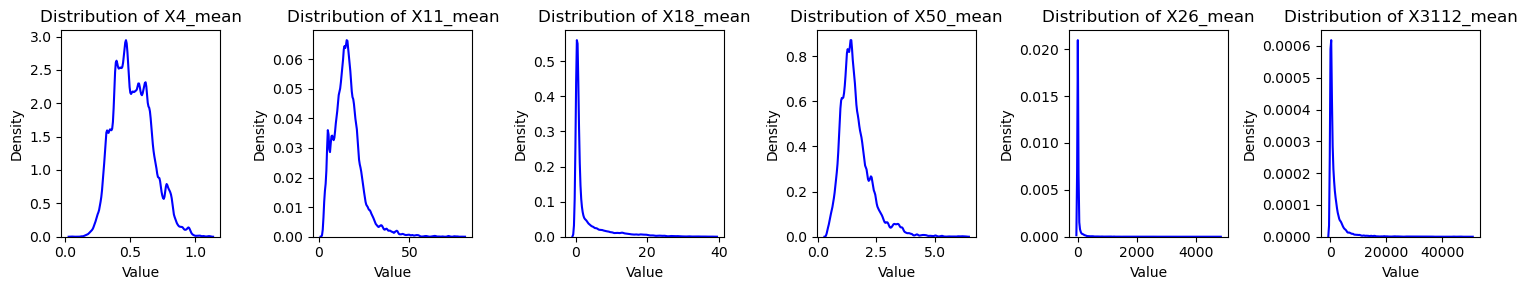

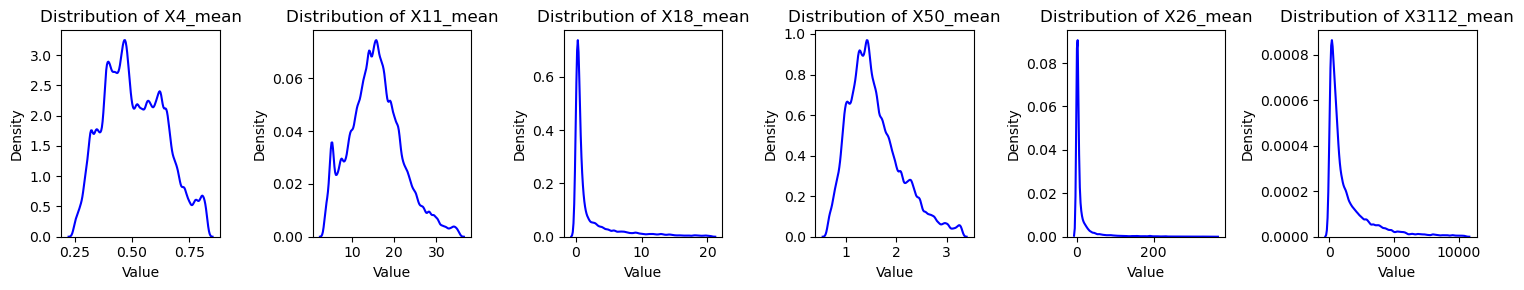

In [12]:
mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

plot_data(train_df, mean_columns)

for column in mean_columns:
    lower_quantile = train_df[column].quantile(0.01)
    upper_quantile = train_df[column].quantile(0.975)  
    train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]
    

plot_data(train_df, mean_columns)

In [13]:
import warnings

# Ohita tietyn tyyppiset varoitukset
warnings.filterwarnings('ignore', category=UserWarning)

# def get_combined_data(df):
#     # Oletetaan, että FEATURES_COLS on jo määritelty olemassa oleville piirteille
#     data = [df[col].values for col in FEATURE_COLS]
#     # Lisää mallin piirteet
#     data.append(np.vstack(df['combined_features'].values))
#     return np.column_stack(data)

def get_features_array(features_series):
    # Muuntaa sarjan, joka sisältää taulukoita, yhdeksi 2D-taulukoksi
    return np.array(list(features_series))

def objective(trial, df, target, fold_train, fold_validation):
    param = {        
        'objective': 'reg:squarederror',
        'device' : 'cuda',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log = True),        
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 142),
        'feature_selector': trial.suggest_categorical('feature_selector', ['shuffle', 'greedy', 'thrifty', 'cyclic', 'random']),
        'boosting': trial.suggest_categorical('boosting', ['gbtree', 'gblinear', 'dart'])

        }
    
    num_total = df['all_features'].iloc[0]
    num_total = len(num_total)
    # print(f'num_total {num_total}')
    
    
    
    folds = [0, 1, 2, 3, 4]
    mse_scores = []
    r2_scores = []

    for fold in folds:

    
        # selector = trial.suggest_categorical('selector', ['f_regression', 'mutual_info_regression', 'none'])
        selector = trial.suggest_categorical('selector', ['none'])
        num_selected = trial.suggest_int('num_selected', 1, num_total - 1)

        train_data = df[df['fold'] != fold]
        valid_data = df[df['fold'] == fold]

        if selector == 'f_regression':
            select = SelectKBest(f_regression, k=num_selected)
        elif selector == 'mutual_info_regression':
            select = SelectKBest(mutual_info_regression, k=num_selected)
        elif selector == 'none':
            select = None

        if select is not None:
            X_train = select.fit_transform(get_features_array(train_data['all_features']), train_data[target])
            X_valid = select.transform(get_features_array(valid_data['all_features']))
            print(f'Selected num {num_selected} with selector {selector}')
            print(f'X_train shape selected {X_train.shape}')
        else:            
            X_train = get_features_array(train_data['all_features'])
            X_valid = get_features_array(valid_data['all_features'])
            # print(f'X_Train not selected shape {X_train.shape}')

        y_train = train_data[target]
        y_valid = valid_data[target]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        num_boost_round = trial.suggest_int('n_estimators', 10, 1420, log=True) 
        
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=watchlist, verbose_eval=False)
        preds = model.predict(dvalid)
        mse = mean_squared_error(y_valid, preds)
        r2 = r2_score(y_valid, preds)

        trial.report(r2, fold)

        if trial.should_prune():
            print(f'Pruned fold {fold} with value {r2} and mse {mse}')
            raise optuna.TrialPruned()

        # print(f'Fold {fold} MSE: {mse} R2: {r2}')
        mse_scores.append(mse)
        r2_scores.append(r2)
    

    tf.keras.backend.clear_session()
    gc.collect()
    
    return np.mean(r2_scores)
    

def optimize_model(df, target, fold_train, fold_validation):

    if os.path.exists(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_qmc_sampler.pickle'):
        with open(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_qmc_sampler.pickle', 'rb') as f:
            print(f'Loading QMC sampler from file {f}')
            qmc_sampler = pickle.load(f)
    else:
        print(f'Creating new QMC sampler')
        qmc_sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)

    if os.path.exists(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_tpe_sampler.pickle'):
        with open(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_tpe_sampler.pickle', 'rb') as f:
            print(f'Loading TPE sampler from file {f}')
            tpe_sampler = pickle.load(f)
    else:
        print(f'Creating new TPE sampler')
        tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=0, multivariate=True, warn_independent_sampling = False)

    if os.path.exists(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_pruner.pickle'):
        with open(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_pruner.pickle', 'rb') as f:
            print(f'Loading pruner from file {f}')
            pruner = pickle.load(f)
    else:
        print(f'Creating new pruner')
        pruner = optuna.pruners.MedianPruner(n_startup_trials=5)

    start_time = time.time()
    study = optuna.create_study(direction='maximize',
                            study_name=study_name,
                            storage=f'sqlite:///513_xgboost_{target}.db',
                            load_if_exists=True                                    
                            )
    
    print(f'Starting optimization for {target} with qmc sampler')
    random_time = time.time()
    study.sampler = qmc_sampler
    study.optimize(lambda trial: objective(trial, df, target, fold_train, fold_validation), n_trials=5)
    print(f'QCM optimization finished in {timedelta(seconds=time.time() - random_time)}')

    print(f'Saving QMC sampler to file ./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_qmc_sampler.pickle')
    with open(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_qmc_sampler.pickle', 'wb') as f:
        pickle.dump(qmc_sampler, f)

    print(f'Starting optimization for {target} with TPE sampler')
    tpe_time = time.time()
    study.sampler = tpe_sampler
    study.optimize(lambda trial: objective(trial, df, target, fold_train, fold_validation), n_trials=20)
    print(f'TPE optimization finished in {timedelta(seconds=time.time() - tpe_time)}')

    print(f'Saving TPE sampler to file ./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_tpe_sampler.pickle')
    with open(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_tpe_sampler.pickle', 'wb') as f:
        pickle.dump(tpe_sampler, f)

    print(f'Saving pruner to file ./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_pruner.pickle')
    with open(f'./NN_search/{study_name}_{fold_train}_{fold_validation}_{target}_pruner.pickle', 'wb') as f:
        pickle.dump(pruner, f)

    print(f'Optimization finished in {timedelta(seconds=time.time() - start_time)}')

    
    



In [14]:
feature_columns = ['model_features_426_convnextbase_003_998_1', 'model_features_511_convnextlarge_3'] 

In [15]:
print(f'Featu {feature_columns}')

Featu ['model_features_426_convnextbase_003_998_1', 'model_features_511_convnextlarge_3']


In [16]:
def prepare_features(df, feature_columns):
    # Yhdistää useita sarakkeita, oletetaan että jokainen arvo on listamuodossa tai pienenä NumPy-taulukkona
    combined_features = np.hstack([np.vstack(df[col].values) for col in feature_columns])
    # Muodosta data lista, jossa on kaikki tarvittavat feature sarakkeet
    data = [df[col].values for col in FEATURE_COLS]
    # Lisää combined_features listaan
    data.append(combined_features)
    # Muunna data NumPy-taulukoksi ja yhdistä sarakkeittain, muunna sitten lista vektoriksi jokaiselle riville
    all_features = np.column_stack(data).tolist()
    # Aseta tämä lista DataFrameen uutena sarakeena
    df['all_features'] = all_features
    return df



train_df_feat = prepare_features(train_df, feature_columns)

In [17]:
test_df_feat = prepare_features(test_df, feature_columns)

In [18]:
train_df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,SOIL_bdod_5.15cm_mean_0.01_deg,SOIL_bdod_60.100cm_mean_0.01_deg,SOIL_cec_0.5cm_mean_0.01_deg,SOIL_cec_100.200cm_mean_0.01_deg,SOIL_cec_15.30cm_mean_0.01_deg,SOIL_cec_30.60cm_mean_0.01_deg,SOIL_cec_5.15cm_mean_0.01_deg,SOIL_cec_60.100cm_mean_0.01_deg,SOIL_cfvo_0.5cm_mean_0.01_deg,SOIL_cfvo_100.200cm_mean_0.01_deg,SOIL_cfvo_15.30cm_mean_0.01_deg,SOIL_cfvo_30.60cm_mean_0.01_deg,SOIL_cfvo_5.15cm_mean_0.01_deg,SOIL_cfvo_60.100cm_mean_0.01_deg,SOIL_clay_0.5cm_mean_0.01_deg,SOIL_clay_100.200cm_mean_0.01_deg,SOIL_clay_15.30cm_mean_0.01_deg,SOIL_clay_30.60cm_mean_0.01_deg,SOIL_clay_5.15cm_mean_0.01_deg,SOIL_clay_60.100cm_mean_0.01_deg,SOIL_nitrogen_0.5cm_mean_0.01_deg,SOIL_nitrogen_100.200cm_mean_0.01_deg,SOIL_nitrogen_15.30cm_mean_0.01_deg,SOIL_nitrogen_30.60cm_mean_0.01_deg,SOIL_nitrogen_5.15cm_mean_0.01_deg,SOIL_nitrogen_60.100cm_mean_0.01_deg,SOIL_ocd_0.5cm_mean_0.01_deg,SOIL_ocd_100.200cm_mean_0.01_deg,SOIL_ocd_15.30cm_mean_0.01_deg,SOIL_ocd_30.60cm_mean_0.01_deg,SOIL_ocd_5.15cm_mean_0.01_deg,SOIL_ocd_60.100cm_mean_0.01_deg,SOIL_ocs_0.30cm_mean_0.01_deg,SOIL_phh2o_0.5cm_mean_0.01_deg,SOIL_phh2o_100.200cm_mean_0.01_deg,SOIL_phh2o_15.30cm_mean_0.01_deg,SOIL_phh2o_30.60cm_mean_0.01_deg,SOIL_phh2o_5.15cm_mean_0.01_deg,SOIL_phh2o_60.100cm_mean_0.01_deg,SOIL_sand_0.5cm_mean_0.01_deg,SOIL_sand_100.200cm_mean_0.01_deg,SOIL_sand_15.30cm_mean_0.01_deg,SOIL_sand_30.60cm_mean_0.01_deg,SOIL_sand_5.15cm_mean_0.01_deg,SOIL_sand_60.100cm_mean_0.01_deg,SOIL_silt_0.5cm_mean_0.01_deg,SOIL_silt_100.200cm_mean_0.01_deg,SOIL_silt_15.30cm_mean_0.01_deg,SOIL_silt_30.60cm_mean_0.01_deg,SOIL_silt_5.15cm_mean_0.01_deg,SOIL_silt_60.100cm_mean_0.01_deg,SOIL_soc_0.5cm_mean_0.01_deg,SOIL_soc_100.200cm_mean_0.01_deg,SOIL_soc_15.30cm_mean_0.01_deg,SOIL_soc_30.60cm_mean_0.01_deg,SOIL_soc_5.15cm_mean_0.01_deg,SOIL_soc_60.100cm_mean_0.01_deg,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_ban

In [19]:
test_df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,SOIL_bdod_5.15cm_mean_0.01_deg,SOIL_bdod_60.100cm_mean_0.01_deg,SOIL_cec_0.5cm_mean_0.01_deg,SOIL_cec_100.200cm_mean_0.01_deg,SOIL_cec_15.30cm_mean_0.01_deg,SOIL_cec_30.60cm_mean_0.01_deg,SOIL_cec_5.15cm_mean_0.01_deg,SOIL_cec_60.100cm_mean_0.01_deg,SOIL_cfvo_0.5cm_mean_0.01_deg,SOIL_cfvo_100.200cm_mean_0.01_deg,SOIL_cfvo_15.30cm_mean_0.01_deg,SOIL_cfvo_30.60cm_mean_0.01_deg,SOIL_cfvo_5.15cm_mean_0.01_deg,SOIL_cfvo_60.100cm_mean_0.01_deg,SOIL_clay_0.5cm_mean_0.01_deg,SOIL_clay_100.200cm_mean_0.01_deg,SOIL_clay_15.30cm_mean_0.01_deg,SOIL_clay_30.60cm_mean_0.01_deg,SOIL_clay_5.15cm_mean_0.01_deg,SOIL_clay_60.100cm_mean_0.01_deg,SOIL_nitrogen_0.5cm_mean_0.01_deg,SOIL_nitrogen_100.200cm_mean_0.01_deg,SOIL_nitrogen_15.30cm_mean_0.01_deg,SOIL_nitrogen_30.60cm_mean_0.01_deg,SOIL_nitrogen_5.15cm_mean_0.01_deg,SOIL_nitrogen_60.100cm_mean_0.01_deg,SOIL_ocd_0.5cm_mean_0.01_deg,SOIL_ocd_100.200cm_mean_0.01_deg,SOIL_ocd_15.30cm_mean_0.01_deg,SOIL_ocd_30.60cm_mean_0.01_deg,SOIL_ocd_5.15cm_mean_0.01_deg,SOIL_ocd_60.100cm_mean_0.01_deg,SOIL_ocs_0.30cm_mean_0.01_deg,SOIL_phh2o_0.5cm_mean_0.01_deg,SOIL_phh2o_100.200cm_mean_0.01_deg,SOIL_phh2o_15.30cm_mean_0.01_deg,SOIL_phh2o_30.60cm_mean_0.01_deg,SOIL_phh2o_5.15cm_mean_0.01_deg,SOIL_phh2o_60.100cm_mean_0.01_deg,SOIL_sand_0.5cm_mean_0.01_deg,SOIL_sand_100.200cm_mean_0.01_deg,SOIL_sand_15.30cm_mean_0.01_deg,SOIL_sand_30.60cm_mean_0.01_deg,SOIL_sand_5.15cm_mean_0.01_deg,SOIL_sand_60.100cm_mean_0.01_deg,SOIL_silt_0.5cm_mean_0.01_deg,SOIL_silt_100.200cm_mean_0.01_deg,SOIL_silt_15.30cm_mean_0.01_deg,SOIL_silt_30.60cm_mean_0.01_deg,SOIL_silt_5.15cm_mean_0.01_deg,SOIL_silt_60.100cm_mean_0.01_deg,SOIL_soc_0.5cm_mean_0.01_deg,SOIL_soc_100.200cm_mean_0.01_deg,SOIL_soc_15.30cm_mean_0.01_deg,SOIL_soc_30.60cm_mean_0.01_deg,SOIL_soc_5.15cm_mean_0.01_deg,SOIL_soc_60.100cm_mean_0.01_deg,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12,MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2,MODIS_2000.2020_monthly_mean_surface_reflectance_ban

In [20]:
testa = train_df_feat['all_features'].iloc[0]
testa = np.array(testa)
print(f'{testa.shape}')

(914,)


In [21]:
testi = train_df_feat['model_features_426_convnextbase_003_998_1'].iloc[0]
testi = np.array(testi)
print(f'{testi.shape}')

(241,)


In [22]:
testi = train_df_feat['model_features_511_convnextlarge_3'].iloc[0]
testi = np.array(testi)
print(f'{testi.shape}')

(510,)


In [23]:
print(f'Feta len {len(FEATURE_COLS)}')

Feta len 163


In [24]:
target_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
train_fold = 80
validation_fold = 1

time_search_start = time.time()
time_taken = 0

while time_taken < 3600 * 18:
    for target in target_columns:    
        print(f'\n\nOptimizing model for {target} using train fold {train_fold} and validation fold {validation_fold}\n\n')
        optimize_model(train_df_feat, target, train_fold, validation_fold)
        time_taken = time.time() - time_search_start
        print(f'Time taken: {timedelta(seconds=time_taken)}')   



Optimizing model for X4_mean using train fold 80 and validation fold 1


Loading QMC sampler from file <_io.BufferedReader name='./NN_search/513_combined_fold_1_3_80_1_X4_mean_qmc_sampler.pickle'>
Loading TPE sampler from file <_io.BufferedReader name='./NN_search/513_combined_fold_1_3_80_1_X4_mean_tpe_sampler.pickle'>
Loading pruner from file <_io.BufferedReader name='./NN_search/513_combined_fold_1_3_80_1_X4_mean_pruner.pickle'>


[I 2024-05-14 13:46:19,848] Using an existing study with name '513_combined_fold_1_3' instead of creating a new one.


Starting optimization for X4_mean with qmc sampler


[I 2024-05-14 13:46:23,626] Trial 113 pruned. 


Pruned fold 0 with value 0.8188214158741773 and mse 0.0031247874005268916


[W 2024-05-14 13:46:29,926] Trial 114 failed with parameters: {'lambda': 0.01778279410038921, 'alpha': 0.01778279410038921, 'colsample_bytree': 0.690625, 'subsample': 0.746875, 'learning_rate': 0.004531583637600819, 'max_depth': 2, 'min_child_weight': 14, 'feature_selector': 'shuffle', 'boosting': 'gblinear', 'selector': 'none', 'num_selected': 257, 'n_estimators': 888} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_398617/2771779924.py", line 137, in <lambda>
    study.optimize(lambda trial: objective(trial, df, target, fold_train, fold_validation), n_trials=5)
  File "/tmp/ipykernel_398617/2771779924.py", line 79, in objective
    model = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=watchlist, verbose_eval=False)
  File "/home/tobias/miniconda3/envs/t

KeyboardInterrupt: 

In [26]:
target_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

train_pred = np.zeros((train_df.shape[0], len(target_columns)))

selectors = {}
models = {}

for i, target in enumerate(target_columns):    

    tf.keras.backend.clear_session()
    gc.collect()
    
    study = optuna.create_study(direction='maximize',
                        study_name=study_name,
                        storage=f'sqlite:///513_xgboost_{target}.db',
                        load_if_exists=True                            
                            )
    
    best_params = study.best_trial.params

    print(f'Best value {study.best_value}')
    print(f'Best params for {target}: {best_params}')
    print(f'Num trials {len(study.trials)}')


    if best_params['selector'] != 'none':
        if best_params['selector'] == 'f_regression':
            print(f'Selector for {target}: {best_params["selector"]} with {best_params["num_selected"]} features')
            select = SelectKBest(f_regression, k=best_params['num_selected'])
            
        else:
            print(f'Selector for {target}: {best_params["selector"]} with {best_params["num_selected"]} features')
            select = SelectKBest(mutual_info_regression, k=best_params['num_selected'])
            
        X_selected = select.fit_transform(get_features_array(train_df_feat['all_features']), train_df_feat[target])
        selectors[target] = select

    else:
                 
        X_selected = get_features_array(train_df_feat['all_features'])
        print(f'None selector in target {target}')
        selectors[target] = None



    del best_params['selector']
    del best_params['num_selected']
    del best_params['feature_selector']

    
    best_params['objective'] = 'reg:squarederror'
    best_params['device'] = 'cuda'

    
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_selected, train_df_feat[target])
    models[target] = model
    
    pred = models[target].predict(X_selected)
    r2 = r2_score(train_df[target], pred)
    mse = mean_squared_error(train_df[target], pred)
    print(f'Training R2 for {target}: {r2} and MSE: {mse}')

    print(f'Model for {target} {models[target]}')

    train_pred[:, i] = models[target].predict(X_selected)


train_r2 = r2_score(train_df_feat[target_columns], train_pred)
print(f'Training R2: {train_r2}')

[I 2024-05-14 13:48:57,105] Using an existing study with name '513_combined_fold_1_3' instead of creating a new one.


Best value 0.7693905663803062
Best params for X4_mean: {'lambda': 1.1616246997633644e-07, 'alpha': 5.6164554956289646e-08, 'colsample_bytree': 0.4337115011062679, 'subsample': 0.7627552814831562, 'learning_rate': 0.014413601543241302, 'max_depth': 15, 'min_child_weight': 66, 'feature_selector': 'random', 'boosting': 'dart', 'selector': 'none', 'num_selected': 464, 'n_estimators': 1119}
Num trials 115
None selector in target X4_mean
Training R2 for X4_mean: 0.9643186099581186 and MSE: 0.000615967990568323
Model for X4_mean XGBRegressor(alpha=5.6164554956289646e-08, base_score=None, booster=None,
             boosting='dart', callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.4337115011062679,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.16162

[I 2024-05-14 14:00:40,657] Using an existing study with name '513_combined_fold_1_3' instead of creating a new one.


Best value 0.7143115113795291
Best params for X11_mean: {'lambda': 3.9991426573461904e-06, 'alpha': 1.378976224723109e-07, 'colsample_bytree': 0.8322680133460857, 'subsample': 0.6366949753308937, 'learning_rate': 0.017153374216928658, 'max_depth': 17, 'min_child_weight': 53, 'feature_selector': 'thrifty', 'boosting': 'gbtree', 'selector': 'none', 'num_selected': 833, 'n_estimators': 1407}
Num trials 75
None selector in target X11_mean
Training R2 for X11_mean: 0.9869055098817947 and MSE: 0.5021591041149337
Model for X11_mean XGBRegressor(alpha=1.378976224723109e-07, base_score=None, booster=None,
             boosting='gbtree', callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8322680133460857,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=3.9

[I 2024-05-14 14:14:36,988] Using an existing study with name '513_combined_fold_1_3' instead of creating a new one.


Best value 0.7588022312241474
Best params for X18_mean: {'lambda': 0.0004143575696568068, 'alpha': 0.009550911578916495, 'colsample_bytree': 0.2518586647118225, 'subsample': 0.8132606675909666, 'learning_rate': 0.016323049700792985, 'max_depth': 15, 'min_child_weight': 57, 'feature_selector': 'cyclic', 'boosting': 'gblinear', 'selector': 'none', 'num_selected': 360, 'n_estimators': 1381}
Num trials 75
None selector in target X18_mean
Training R2 for X18_mean: 0.9847917418037977 and MSE: 0.22975686910843574
Model for X18_mean XGBRegressor(alpha=0.009550911578916495, base_score=None, booster=None,
             boosting='gblinear', callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.2518586647118225,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.

[I 2024-05-14 14:17:33,547] Using an existing study with name '513_combined_fold_1_3' instead of creating a new one.


Best value 0.689668194976391
Best params for X50_mean: {'lambda': 8.001469694636504e-05, 'alpha': 3.3210706675115165e-07, 'colsample_bytree': 0.853487877521101, 'subsample': 0.6499935795790138, 'learning_rate': 0.015408031118600701, 'max_depth': 19, 'min_child_weight': 95, 'feature_selector': 'greedy', 'boosting': 'gblinear', 'selector': 'none', 'num_selected': 263, 'n_estimators': 1083}
Num trials 75
None selector in target X50_mean
Training R2 for X50_mean: 0.9369738977102174 and MSE: 0.017195872911732923
Model for X50_mean XGBRegressor(alpha=3.3210706675115165e-07, base_score=None, booster=None,
             boosting='gblinear', callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.853487877521101,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=

[I 2024-05-14 14:19:49,747] Using an existing study with name '513_combined_fold_1_3' instead of creating a new one.


Best value 0.5452420963385447
Best params for X26_mean: {'lambda': 1.7983221181197684e-07, 'alpha': 3.922179402164623e-05, 'colsample_bytree': 0.4273007883405952, 'subsample': 0.8386553951534269, 'learning_rate': 0.021931095421911344, 'max_depth': 17, 'min_child_weight': 71, 'feature_selector': 'thrifty', 'boosting': 'gblinear', 'selector': 'none', 'num_selected': 717, 'n_estimators': 1305}
Num trials 75
None selector in target X26_mean
Training R2 for X26_mean: 0.9781541930979085 and MSE: 38.42099101410525
Model for X26_mean XGBRegressor(alpha=3.922179402164623e-05, base_score=None, booster=None,
             boosting='gblinear', callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.4273007883405952,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=

[I 2024-05-14 14:23:09,121] Using an existing study with name '513_combined_fold_1_3' instead of creating a new one.


Best value 0.7107413466087242
Best params for X3112_mean: {'lambda': 1.5328375053682185e-06, 'alpha': 1.1229450560897261e-07, 'colsample_bytree': 0.3332275519953571, 'subsample': 0.8862238855499829, 'learning_rate': 0.010692166516157333, 'max_depth': 17, 'min_child_weight': 57, 'feature_selector': 'random', 'boosting': 'dart', 'selector': 'none', 'num_selected': 508, 'n_estimators': 1356}
Num trials 58
None selector in target X3112_mean
Training R2 for X3112_mean: 0.9656738544177927 and MSE: 110263.23563168844
Model for X3112_mean XGBRegressor(alpha=1.1229450560897261e-07, base_score=None, booster=None,
             boosting='dart', callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.3332275519953571,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambd

In [27]:


test_preds = np.zeros((len(test_df), len(target_columns)))

for i, target in enumerate(target_columns):
    print(f'Predicting {target} with model {models[target]}')
  
    if selectors[target] is not None:
        X_selected = selectors[target].transform(get_features_array(test_df_feat['all_features']))
    else:
        X_selected = get_features_array(test_df_feat['all_features'])

    test_preds[:, i] = models[target].predict(X_selected)
     

Predicting X4_mean with model XGBRegressor(alpha=5.6164554956289646e-08, base_score=None, booster=None,
             boosting='dart', callbacks=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.4337115011062679,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.1616246997633644e-07,
             learning_rate=0.014413601543241302, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=66, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1119, ...)
Predicting X11_mean with model XGBRegressor(alpha=1.378976224723109e-07, base_score=None, booster=None,
             boosting='gbtree', callbacks=None, colsampl

In [28]:
target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

test_df_copy = test_df.copy()
submission_df = test_df_copy[['id']].copy()
submission_df[target_columns] = test_preds

In [29]:
submission_df.describe()

,id,X4,X11,X18,X50,X26,X3112
count,6.545000e+03,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000
mean,1.930247e+08,0.512166,15.789399,2.633335,1.555221,17.624178,1475.643201
std,2.601377e+07,0.109149,5.486434,3.639728,0.419218,32.381660,1577.522033
min,1.040495e+06,0.251366,3.628575,-0.022011,0.636011,-11.641953,-29.340454
25%,1.971690e+08,0.426471,12.274532,0.375357,1.251223,0.966750,385.178467
50%,2.008276e+08,0.505180,15.878145,0.746433,1.500759,3.556053,849.057434
75%,2.022672e+08,0.594898,19.200815,3.462933,1.792205,17.455410,1982.533447
max,2.030654e+08,0.822844,33.241577,18.029301,3.235028,249.549530,8941.765625


In [30]:
target_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
train_df[target_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,43509.000000,43509.000000,43509.000000,43509.000000,43509.000000,43509.000000
mean,0.511514,15.625733,2.421330,1.573917,16.816282,1413.171914
std,0.131390,6.192719,3.886865,0.522344,41.937760,1792.288166
min,0.245330,3.398098,0.050324,0.633466,0.013573,15.922700
25%,0.408366,11.416037,0.306775,1.201039,0.561341,270.990904
50%,0.495921,15.384302,0.647856,1.471772,2.204306,673.665571
75%,0.611469,19.358943,2.569238,1.863838,10.778422,1843.113747
max,0.828565,35.467667,20.489862,3.303960,360.567402,10506.215591


In [31]:
submission_df.head()

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.631263,7.501130,2.927251,1.825450,8.418954,391.521423
1,202310319,0.524851,23.087097,0.439740,1.062362,-0.099461,1124.381470
2,202604412,0.605403,18.908113,1.568295,1.036356,4.774509,912.936890
3,201353439,0.515849,20.222631,0.165807,1.233577,1.488158,1811.687622
4,195351745,0.521793,6.528090,0.088879,1.720751,-1.367685,234.539307


In [32]:
submission_df.to_csv('./data/submission.csv', index=False)

: 